# Opinion Shaping in Social Networks Using Reinforcement Learning

The article we study aims to understand opinion propagation and opinion shaping in social networks, and propose different algorithms with an opinion shaping optimzation problem: 

The social network is represented as follows: 
The graph $G$ has :
-  A set of agents, or nodes $S$
-  A set of edges between nodes

The edges $(i,j)$ are weighted by a value $p_{ij}$ and bidirectionnal, representing the probability of being influenced by ones acquaintance. Thus, for an agent $i$, we have $\sum_{j \in S} p_{ji} = 1$
Each agent $i$ has his own opinion $x_i$, that can evolve in time.
This opinion represent the "agreement" with a planner that can partially control the opinion of agents. $x_i = 0$ then representing having an opinion opposite to the planner, and $x_i = 1$ means the agent $i$ agrees with the planner.

The agents can be separated into 3 categories: 
 - The "Stubborns" agents (S0) never change their opinion: $x_i(k) = h(i) \forall k$
 - The "Uncontrollable" agents (S1) can change their opinion, when they do so, they poll one of their neighbors with the probabilities $p_{ij}$, and take their opinion.
 - The "Controlable" agents (S2) can also change their opinion. When they do so, they have a probability $\alpha_i$ to be controlled by the planner, changing their opinion with $x_i(k+1) = w_i(u_i)$ where $u_i \in R$ represent the control the planner can put on the agent, and $w_i$ a function that convert this control in an opinion between 0 and 1. 
 They then have a probability $1-\alpha_i$ to change their opinion like S1 agents

Using the expectation of the $x_i$, we can show that $\lim_{k\to \infty} \bar{x}_i(k) = x_i^*$ respects the following equations: 

$$ 
x_i^* = \alpha _i w_i(u_i) + (1-\alpha _i) \sum_{l\in S}p_{il}x_l^*, i \in S2 \\

x_i^* = \sum_{l\in S}p_{il}x_l^*, i \in S1\\

x_i^* = h(i), i \in S0
$$

For the planner, the optimization problem is then to maximize the $x_i^*$, so $\sum_{i \in S} x_i^* $ by controlling the $u_i$ values. To this problem we add a budget constraint M such that $\sum_{i \in S2} u_i \le M$

## Libs

In [31]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx
import time
import random
import math

from code_generation_graph import creation_graph, show_graph
from utils import Gamma, a, b, w, dw, mat_A, mat_H, mat_WS0, mat_WS2

## Graph Creation

We need to create a graph that fit the Opinion Shaping in Social Networks problem. At first, we must create a graph with 3 categories/status of nodes: S0, S1 and S2. Representing three types of subjects the stubborn agents, the controlled agents and the uncontrolled one.

We associate node with a status randomly between the three states. We then associate each node with a position between 0 and 1 representing adhesion to the idea. This position is picked uniformly between 0 and 1 at first.  
 
For the nodes that are controlled agents we need to create another attribute to represent the probability of being influenced by the state. We choose to pick this probability named alpha by a uniform law between 0 and 1 as the graph is supposed to be random.   

Then we create the links between the nodes with a random number of links per nodes and a random weight associated to each node, representing the probability of each node to influence the next one. Those weight are then adjusted to fit the sum of the probability equal to 1. The graph is then completed and ready to be used in our algorithms.

### Simulation of the doc graph

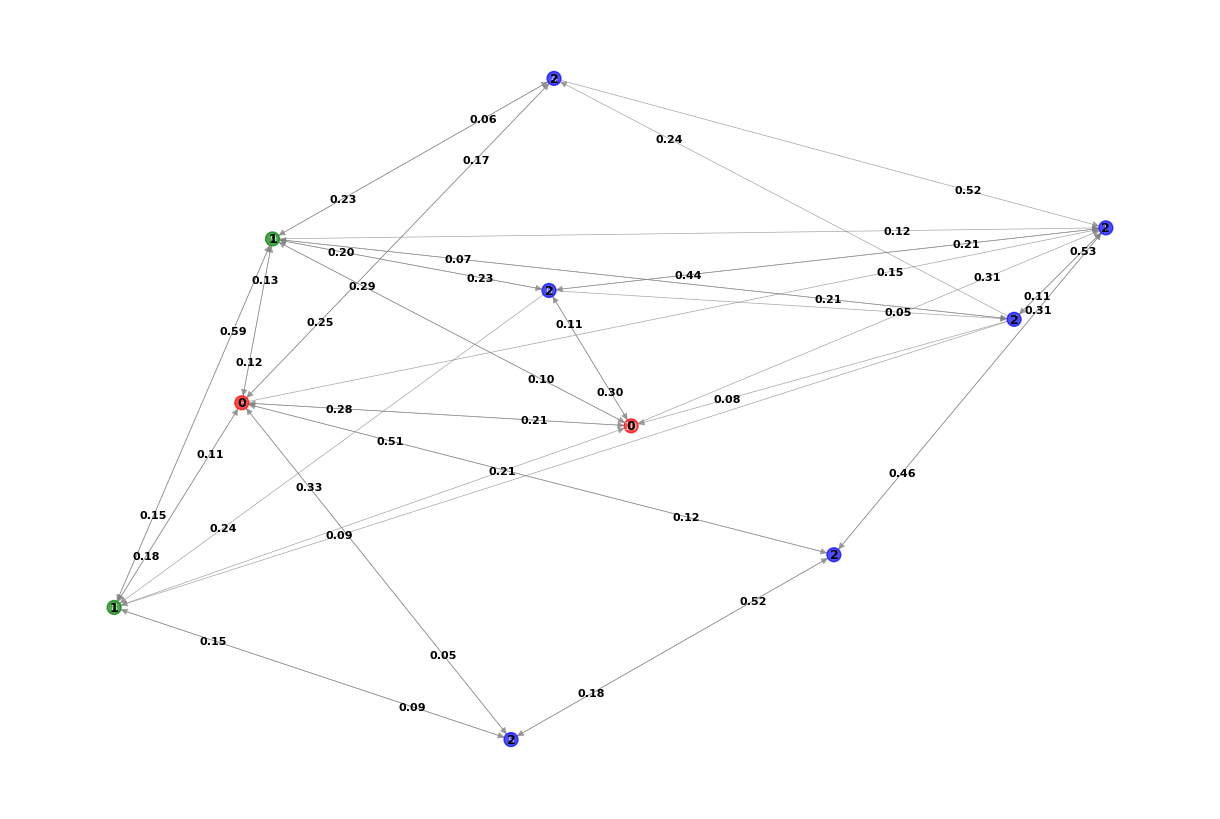

In [32]:
# first with a graph of size 10
Graph = creation_graph(10)
show_graph(Graph)

## Algorithms

### With full knowledge

With full knowledge of the graph, the problem of maximizing the opinions is relatively easy, as the final opinions vector $x^*$ is just the solution of the fixed point problem:  


$$ 
x_i^* = \alpha _i w_i(u_i) + (1-\alpha _i) \sum_{l\in S}p_{il}x_l^*, i \in S1 \cup S2 \\

x_i^* = h(i), i \in S0
$$

If we define 
$$ 
A = a_{ij, 1\le i,j \le n} = (1-1_{i\in S_0})(1-1{i\in S_2}\alpha _i)p_{ij} \\
\text{and } W(u) = W_i(u) = 1_{i \in S_2} \alpha _i w_i (u_i) + 1_{i\in S_0} h(i)
$$

Then the solution $x^*$ is :
$$
x^* = (Id - A)^{-1}W(u)
$$

Our optimization problem objective becomes :  

$$
u* = argmax_{u_i \in R^+, i \in S_2} 1^T (Id - A)^{-1}W(u)\\

s.t \sum_{i \in S_2} u_i \le M
$$

To solve the optimization problem we use a typical gradient ascent (not descent as we search a maximum) with the following algorithm:

At step k, do the following: 

> $u_i(k+1) = \Gamma \left( u_i(k) + \frac{1}{k} 1^T (Id - A)^{-1}\frac{\partial W}{\partial u_i}(u(k)) \right)$

Where $\Gamma$ is a projection map that ensure the constraint and $\frac{\partial W}{\partial u_i}(u(k)) = \left[1_{j\in S_2} \alpha _j \frac{\partial w_j}{\partial u_i}(u_j) \right]_{j\in S}$.

The following code is a simulation of the Gradient ascent on the graph created before

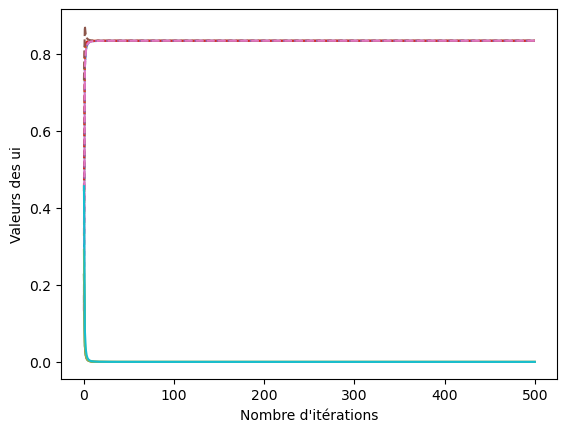

In [34]:
N = Graph.number_of_nodes()
M = 5
N_iter = 500

A = mat_A(Graph)
Id = np.identity(N)
block_mat_inv = np.linalg.inv(Id - A)

vect_unit_T = np.ones((1,N))


U = np.zeros((N,1))
for k in range(N):
  U[k] = random.uniform(0, 2*M/N)
S = sum(U)
if  S > M :
  for k in range(N):
    U[k] = U[k]*M/S

Alpha = mat_WS2(Graph)
unit_t_Id_A_inv = np.dot(vect_unit_T, block_mat_inv)

index_S2 = []
for k in range(N):
  if Graph.nodes[k+1]['status'] == 2 :
    index_S2.append(k)

U_k = np.zeros((N,N_iter+1))

for k in range(1, N_iter+1):
  U_k[:,k-1] = np.transpose(U)[0]
  for i in index_S2:
    U[i] = U[i] + (1/k) * np.dot(unit_t_Id_A_inv,np.multiply(Alpha , np.matrix(dw(U_k[:,k-1])).T))
  S = sum(U)
  if  S > M :
    for k in range(N):
      U[k] = U[k]*M/S
U_k[:,N_iter] = np.transpose(U)[0]



for k in range(N):
  les_y = [x for x in U_k[k]]
  if k in index_S2 :
    plt.plot(les_y, label='controlled agents', linestyle='--')
  else:
    plt.plot(les_y, label='other agents')
plt.xlabel("Nombre d'itérations")
plt.ylabel("Valeurs des ui")
plt.show()

### Without knowledge of P

The first algorithm needs the full knowledge of P, which, in real life, means knowing how much everyone in the social network is susceptible to be influenced by everyone. 
This data is clearly impossible do find, even using surveys, as most people wouldn't be able to answer this question: how much each of your acquaintance can influence your opinion? 

To be able to compute the best solution of the algorithm without the knowledge of P, the hypothesis is that the planner can "observes" the communication between 2 agents when one polls another, thus understanding the impact of the polled agent on the first one.

The algorithm works as follows: 

We initialize vector $u$ of control applied to S2 agents with random values
We initialize matrix $\Psi$ of size $(\#S, \#S2)$ with 0-filled columns where line index is in S0, and random values otherwise. Such as $\Psi_{ij} = 0$ if $i \in S0$  
Set $\alpha_i = 0 \text{ for }i \in S1$ 

At step k:

We randomly choose a node $Z_k$ in the graph  
We randomly choose one of its neighbors $\tilde{Z}_k$ with the probability $p_{Z_k \tilde{Z}_k}$  
for each agent i in S2 X S1 and
for each agen j in S2, do the following:  
> $\Psi_{ij}(k+1) = \Psi_{ij}(k)$  
> if agent i is node $Z_k$  
>> $\Psi_{ij}(k+1) += a(k,i) \times ((1-\alpha _i) \Psi_{\tilde{Z}_kj}(k) - \Psi_{ij}(k))$  
>> if i = j  
>>> $\Psi_{ij}(k+1) += a(k,i) \times (\alpha _i w'_i(u_i(k)))$  

> if agent i is in S2  
>> $u_i(k+1) = u_i(k) + b(k)\sum_j \Psi_{ji}(k)$  
> $u(k+1) = \Gamma(u(k))$  

Where $a(k,i)$ and $b(k)$ have specific properties, such as being decreasing in k, a decreasing faster than b, and the value of a being smaller the more node i has been picked as $Z_k$. 

#### Proof 

We can prove that this algorithm actually converges to the desired values:

Recall the equations : 

$$ 
x_i^* = \alpha _i w_i(u_i) + (1-\alpha _i) \sum_{l\in S}p_{il}x_l^*, i \in S1 \cup S2 \\

x_i^* = h(i), i \in S0
$$

If we derive these equations is respect to the $u_i$, we obtain the following equation: 
$$
\Phi_{ij} = \frac{\partial x_i^*}{\partial u_j} = \alpha _i w'_i(u_i)\delta _{ij} + (1-\alpha _i)\sum _l p_{il}\Phi_{lj}
$$

The only difference between this equation and the added term each step in the algorithm ($\alpha _i w'_i(u_i)\delta _{ij} + (1-\alpha _i)\Psi_{\tilde{Z}_kj}$) is that the sum is replaced with the evaluation of $\Psi$ conditionned by the $p_i$. As the value of $\tilde{Z}_k$ is chosen through the $p_{ij}$, If node i is sampled enough times so that each of its neighbors is chosen a significant amount of times, the value of the estimator of $\Phi_{ij}$ would be close to its mean, and we have $E(\Psi_{\tilde{Z}_kj}) = \sum _l p_{il}\Psi_{lj}$

We now see that $\Psi_{ij}$ estimates $\frac{\partial x_i^*}{\partial u_j}$

We Then have a stochastic gradient ascent, where at each step we modify the estimator of $\frac{\partial x_i^*}{\partial u_j}$ using its estimator and a stepsize a, and we update the $u_i$s by adding the sum of $\Psi$ values on the first index, which, if we replace it by what it estimates, gives us: $\sum _j \Psi_{ji} = \sum_j \frac{\partial x_j^*}{\partial u_i} = \frac{\partial \sum _j x_j^*}{\partial u_i}$ Which is the variation of the reward due to $u_i$. The function $\Gamma$ Then projects our new $u$ on the constraint space.

#### Simulation

The cell below creates all necessary data to do the algorithm and to plot the graphs

In [35]:
n = Graph.number_of_nodes()
e = Graph.number_of_edges()

P = np.zeros((n,n)) 
#Although we don't need access to the whole matrix P,
# it is useful to compute it to observe the links between Z[k] and Z~[k], and to compare algorithms
for i,j,data  in Graph.edges.data():
    P[i-1,j-1] = data['weight']

S = {0:[],
     1:[],
     2:[]} # We create a dictonnary with each node in each group

alpha = np.zeros(n)

for i,data in Graph.nodes.data():
    S[data['status']].append(i)
    alpha[i-1] = data['alpha']



u = np.zeros(n)
u[np.array(S[2])-1] = np.random.random(len(S[2])) #initialize only the nodes of S2 with random values

Max_iter = 50000
u_vec = np.zeros((Max_iter,n))
u_vec[0,:] = u
v = np.zeros(n) #vector to count the number of times each node has been sampled, used in stepsize a

Psi = np.random.random((n,n))
Psi[np.array(S[0])-1,:] = 0

Psi_vec = np.zeros((Max_iter,n,n))
Psi_vec[0,:,:] = Psi

Z = np.zeros(Max_iter,dtype = 'int')
Z_tilde = np.zeros(Max_iter,dtype = 'int')


B = 0.6
C = 100
A = 0.6 #Coefficients for a and b stepsizes

M = 5 #Constraint sum(u) < M

In [36]:
#Main algorithm
for k in range(Max_iter-1):
    Z[k] = random.choice(list(Graph.nodes.keys())) #randomly sample node Z[k]
    v[Z[k]-1]+=1 #add 1 to the counter
    Z_tilde[k] = random.choices(list(Graph.nodes.keys()),weights = P[Z[k]-1,:])[0] #Sample Z~ with the rights probabilities
    if Z[k] in S[1]+S[2]:
        for i in S[1]+S[2]:
            for j in S[2]:
                Psi[i-1,j-1] += b(v[i-1],B,C)*(Z[k]==i)*((1-alpha[i-1])*Psi[Z_tilde[k]-1,j-1] - Psi[i-1,j-1])
                if i in S[2]:
                    Psi[i-1,j-1] += b(v[i-1],B,C)*(Z[k]==i)*alpha[i-1]*dw(u[i-1])*(i==j)
                    u[i-1] += a(k,A,C)*np.sum(Psi[:,i-1])
    u = Gamma(u,M,S[2])
    u_vec[k+1] = u
    Psi_vec[k+1] = Psi


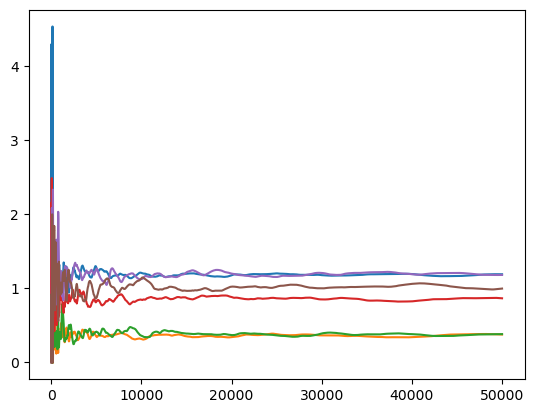

In [45]:
for i in S[2]:
    plt.plot(u_vec[:,i-1])